# Topic modelling and sentiment analysis

## Imports 

In [24]:
import re
import warnings
import gensim
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from gensim import corpora
from wordcloud import WordCloud, STOPWORDS
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

/Users/ea/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data reading 

In [25]:
tweets = pd.read_csv("./clean_tweets.csv")
tweets[:2]

,created_at,original_text,polarity,subjectivity,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,place,hashtags_in_tweets,screen_name,device
0,2021-06-18 17:55:49+00:00,africa is in the midst of a full blown third...,0.166667,0.188889,548,612,ketuesriche,551,351,False,,mass,,"@telglobalhealth, @telglobalhealth",twitter for iphone
1,2021-06-18 17:55:59+00:00,dr moeti is head of who in africa and one of ...,0.133333,0.455556,195,92,grid1949,66,92,False,,"edinburgh, scotland",,@globalhlthtwit,twitter web app


In [26]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   original_text       6532 non-null   object 
 2   polarity            6532 non-null   float64
 3   subjectivity        6532 non-null   float64
 4   favorite_count      6532 non-null   int64  
 5   retweet_count       6532 non-null   int64  
 6   original_author     6532 non-null   object 
 7   followers_count     6532 non-null   int64  
 8   friends_count       6532 non-null   int64  
 9   possibly_sensitive  6532 non-null   bool   
 10  hashtags            6532 non-null   object 
 11  place               6532 non-null   object 
 12  hashtags_in_tweets  6532 non-null   object 
 13  screen_name         6532 non-null   object 
 14  device              6532 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(8)
memory usag

## Topic modelling

## Feature Extraction

We will create a dataset containg only the columns we need for topic modeling.

In [27]:
df = pd.DataFrame(columns=['clean_text', 'polarity'])

df['clean_text'] = tweets['original_text'].astype(str)
df['polarity'] = tweets['polarity']
df[:2]

,clean_text,polarity
0,africa is in the midst of a full blown third...,0.166667
1,dr moeti is head of who in africa and one of ...,0.133333


### Data Pre-processing

I have already done common data preprocessing tasks like, converting to lowercase, removing Punctuation and links. Here we will go further and make the data ready for topic modelling.

### Remove stop words

In [28]:
freqX = pd.Series(
    ' '.join(df['clean_text']).split()).value_counts()[:10]

print('FREQ X: \n', freqX)

FREQ X: 
 the         7191
to          6094
vaccines    4462
of          4162
and         3501
in          3499
#covid      3086
a           2397
is          2261
are         1986
dtype: int64


As we can see most them are stop words so should we remove them. While exploring the data, I have also found while exploring the data using word cloud, there are some meaning less characters in the data. we will also remove those.

In [29]:
custom_stopwords = ['t', 'rt', 'ti', 'vk', 'to', 'co',
                    'dqlw', 'z', 'nd', 'm', 's', 'kur', 'u', 'o', 'd']
STOP_WORDS = STOPWORDS.union(custom_stopwords)

#### Tokenizing


In [30]:
tweets['clean_text'] = tweets['original_text'].astype(str)
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: x.lower())
tweets['clean_text'] = tweets['clean_text'].apply(
    lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [31]:
sentence_list = []
for w in tweets['clean_text']:
    if w not in STOP_WORDS:
        sentence_list.append(w)

len(sentence_list)

6532

In [32]:
word_list = [sent.split() for sent in sentence_list]

In [33]:
print(word_list[:2])

[['africa', 'is', 'in', 'the', 'midst', 'of', 'a', 'full', 'blown', 'third', 'wave', 'of', 'coronavirus', 'the', 'head', 'of', 'whoafro', 'has', 'warned', 'cases', 'have', 'risen', 'across', 'the', 'continent', 'by', 'more', 'than', 'and', 'deaths', 'have', 'also', 'risen', 'by', 'in', 'the', 'last', 'week', 'jriggers', 'reports'], ['dr', 'moeti', 'is', 'head', 'of', 'who', 'in', 'africa', 'and', 'one', 'of', 'the', 'best', 'public', 'health', 'experts', 'and', 'leaders', 'i', 'know', 'hers', 'is', 'a', 'desperate', 'request', 'for', 'vaccines', 'to', 'africa', 'we', 'plead', 'with', 'germany', 'and', 'the', 'uk', 'to', 'lift', 'patent', 'restrictions', 'and', 'urgently', 'transfer', 'technology', 'to', 'enable', 'production', 'in', 'africa']]


### Lemmatization

In [34]:
lemmatizer = WordNetLemmatizer()
word_list_lematized = []

for w in word_list:
    word_list_lematized.append([lemmatizer.lemmatize(x) for x in w])
print(word_list_lematized[:2])

[['africa', 'is', 'in', 'the', 'midst', 'of', 'a', 'full', 'blown', 'third', 'wave', 'of', 'coronavirus', 'the', 'head', 'of', 'whoafro', 'ha', 'warned', 'case', 'have', 'risen', 'across', 'the', 'continent', 'by', 'more', 'than', 'and', 'death', 'have', 'also', 'risen', 'by', 'in', 'the', 'last', 'week', 'jriggers', 'report'], ['dr', 'moeti', 'is', 'head', 'of', 'who', 'in', 'africa', 'and', 'one', 'of', 'the', 'best', 'public', 'health', 'expert', 'and', 'leader', 'i', 'know', 'hers', 'is', 'a', 'desperate', 'request', 'for', 'vaccine', 'to', 'africa', 'we', 'plead', 'with', 'germany', 'and', 'the', 'uk', 'to', 'lift', 'patent', 'restriction', 'and', 'urgently', 'transfer', 'technology', 'to', 'enable', 'production', 'in', 'africa']]


### Model

In [35]:
#Create dictionary which contains Id and word
id2word = corpora.Dictionary(word_list_lematized)
corpus = [id2word.doc2bow(tweet) for tweet in word_list]


In [36]:
print(np.array(word_list).shape)
print(np.array(id2word).shape)
print(np.array(corpus).shape)

(6532,)
(6244,)
(6532,)


In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [38]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('rt', 0.05135388),
   ('to', 0.04899923),
   ('you', 0.047530957),
   ('just', 0.04639975),
   ('by', 0.04287168),
   ('your', 0.040858533),
   ('israel', 0.039500218),
   ('expired', 0.036287107),
   ('another', 0.036159504),
   ('off', 0.034197006)]),
 (1,
  [('the', 0.055367418),
   ('india', 0.04609642),
   ('of', 0.045332506),
   ('in', 0.035756595),
   ('covid', 0.03425202),
   ('to', 0.03176906),
   ('a', 0.023968818),
   ('africa', 0.020553645),
   ('and', 0.01960582),
   ('you', 0.01767912)]),
 (2,
  [('the', 0.04535592),
   ('covid', 0.044756),
   ('to', 0.04405555),
   ('are', 0.0225899),
   ('of', 0.020903906),
   ('and', 0.018832086),
   ('in', 0.017606916),
   ('s', 0.016779993),
   ('for', 0.015218426),
   ('amp', 0.0148701705)]),
 (3,
  [('dose', 0.059763003),
   ('capacity', 0.041330624),
   ('age', 0.038345903),
   ('code', 0.034806795),
   ('pin', 0.03457041),
   ('limit', 0.03457005),
   ('min', 0.03457005),
   ('covaxin', 0.029363401),
   ('pmcg', 0.022434

In [39]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)



Perplexity:  -6.145317042964687

 Ldamodel Coherence Score/Accuracy on Tweets:  0.46964481291085464


### Visualization

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [60]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)


##  Sentiment analysis

### Form a new data frame (named `cleanTweet`), containing columns $\textbf{clean-text}$ and $\textbf{polarity}$

In [42]:
cleanTweet = pd.DataFrame(columns=['original_text', 'clean_text'])

cleanTweet['original_text'] = tweets['original_text'].to_list()

In [43]:
def clean_tweet(tweet):
    clean_tweet = re.sub("[^a-zA-Z]",  " ",  tweet)
    return clean_tweet

In [44]:
cleanTweet["clean-text"] = cleanTweet.original_text.apply(clean_tweet)
tweets.drop(['original_text'], axis=1, inplace=True)
cleanTweet


,original_text,clean_text,clean-text
0,africa is in the midst of a full blown third...,NaN,africa is in the midst of a full blown third...
1,dr moeti is head of who in africa and one of ...,NaN,dr moeti is head of who in africa and one of ...
2,thank you research note for creating this ama...,NaN,thank you research note for creating this ama...
3,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...
4,i think it s important that we don t sell cova...,NaN,i think it s important that we don t sell cova...
...,...,...,...
6527,rt givenkazeni zweli please just release the...,NaN,rt givenkazeni zweli please just release the...
6528,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...
6529,jenfeds dcrinyyc respectfully veterinaria...,NaN,jenfeds dcrinyyc respectfully veterinaria...
6530,africa needs millions more doses here amp n...,NaN,africa needs millions more doses here amp n...


In [45]:
print("duplicate count: {}".format(cleanTweet.isnull().sum().sum()))

duplicate count: 6532


### Write a function `text_category` that takes a value `p` and returns, depending on the value of p, a string `'positive'`, `'negative'` or `'neutral'`.

In [46]:
def text_category(p):
  if p > 0:
    return "positive"
  elif p < 0:
    return "negative"
  else:
    return "neutral"

### Apply this function (`text_category`) on the $\textbf{polarity}$ column of `cleanTweet` in 1 above to form a new column called $\textbf{score}$ in `cleanTweet`.

In [47]:
cleanTweet["score"] = tweets["polarity"].apply(text_category)
cleanTweet

,original_text,clean_text,clean-text,score
0,africa is in the midst of a full blown third...,NaN,africa is in the midst of a full blown third...,positive
1,dr moeti is head of who in africa and one of ...,NaN,dr moeti is head of who in africa and one of ...,positive
2,thank you research note for creating this ama...,NaN,thank you research note for creating this ama...,positive
3,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive
4,i think it s important that we don t sell cova...,NaN,i think it s important that we don t sell cova...,positive
...,...,...,...,...
6527,rt givenkazeni zweli please just release the...,NaN,rt givenkazeni zweli please just release the...,neutral
6528,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive
6529,jenfeds dcrinyyc respectfully veterinaria...,NaN,jenfeds dcrinyyc respectfully veterinaria...,positive
6530,africa needs millions more doses here amp n...,NaN,africa needs millions more doses here amp n...,positive


### Visualize The $\textbf{score}$ column using piechart and barchart

In [48]:
category = cleanTweet.groupby(['score']).size()
category

score
negative    1277
neutral     1829
positive    3426
dtype: int64

<AxesSubplot:ylabel='None'>

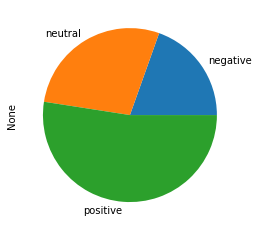

In [49]:
category.plot(kind='pie', y='score')

<AxesSubplot:xlabel='score'>

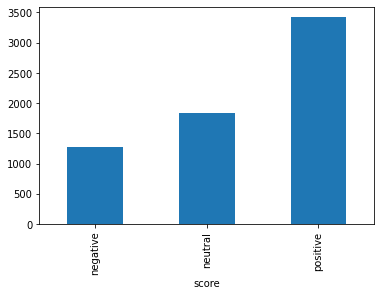

In [50]:
category.plot(kind='bar', y='score')

## build a classification model on the clean tweet.

### Remove rows from `cleanTweet` where $\textbf{polarity}$ $= 0$ (i.e where $\textbf{score}$ = Neutral) and reset the frame index.

In [51]:
cleanTweet = cleanTweet[cleanTweet['score'] != 'neutral']
cleanTweet

,original_text,clean_text,clean-text,score
0,africa is in the midst of a full blown third...,NaN,africa is in the midst of a full blown third...,positive
1,dr moeti is head of who in africa and one of ...,NaN,dr moeti is head of who in africa and one of ...,positive
2,thank you research note for creating this ama...,NaN,thank you research note for creating this ama...,positive
3,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive
4,i think it s important that we don t sell cova...,NaN,i think it s important that we don t sell cova...,positive
...,...,...,...,...
6524,covid vaccines reach the remotest places of ...,NaN,covid vaccines reach the remotest places of ...,negative
6526,although there is not yet a vaccine for kids t...,NaN,although there is not yet a vaccine for kids t...,positive
6528,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive
6529,jenfeds dcrinyyc respectfully veterinaria...,NaN,jenfeds dcrinyyc respectfully veterinaria...,positive


### Construct a column $\textbf{scoremap}$ Use the mapping {'positive':1, 'negative':0} on the $\textbf{score}$ column

In [52]:
cleanTweet['scoremap'] = cleanTweet["score"].map( lambda score: 1 if score == "positive" else 0)
cleanTweet

,original_text,clean_text,clean-text,score,scoremap
0,africa is in the midst of a full blown third...,NaN,africa is in the midst of a full blown third...,positive,1
1,dr moeti is head of who in africa and one of ...,NaN,dr moeti is head of who in africa and one of ...,positive,1
2,thank you research note for creating this ama...,NaN,thank you research note for creating this ama...,positive,1
3,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive,1
4,i think it s important that we don t sell cova...,NaN,i think it s important that we don t sell cova...,positive,1
...,...,...,...,...,...
6524,covid vaccines reach the remotest places of ...,NaN,covid vaccines reach the remotest places of ...,negative,0
6526,although there is not yet a vaccine for kids t...,NaN,although there is not yet a vaccine for kids t...,positive,1
6528,former pfizer vp and virologist dr michael y...,NaN,former pfizer vp and virologist dr michael y...,positive,1
6529,jenfeds dcrinyyc respectfully veterinaria...,NaN,jenfeds dcrinyyc respectfully veterinaria...,positive,1


### Create feature and target variables `(X,y)` from $\textbf{clean-text}$ and $\textbf{scoremap}$ columns respectively.

In [53]:
(X, y) = cleanTweet['clean-text'], cleanTweet['scoremap']

### Use `train_test_split` function to construct `(X_train, y_train)` and `(X_test, y_test)` from `(X,y)`

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Build an `SGDClassifier` model from the vectorize train text data. Use `CountVectorizer()` with a $\textit{trigram}$ parameter and Evaluate your model on the test data.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [57]:
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit_transform(X)

<4703x21713 sparse matrix of type '<class 'numpy.int64'>'
	with 133587 stored elements in Compressed Sparse Row format>

In [58]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit_transform(X.values)

X_trigram = trigram_vectorizer.transform(X)


def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [59]:
train_and_show_scores(X_trigram, cleanTweet['scoremap'], title="sentiment")

sentiment
Train score: 1.0 ; Validation score: 0.96

